# Swissroll Example

### Imports

In [1]:
from sklearn import datasets, neighbors, preprocessing
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

# local imports
from os import chdir
chdir("../")

from lllvm import LL_LVM
from lllvm.plot import plot_C_arrows, plot_G
from lllvm.utils import infer_graph, initialize_t, initialize_C

chdir("demo")

# Plotting configuration
%matplotlib inline
#sns.set()

# Simulation Data

In [2]:
np.random.seed(10)

x, t_true = datasets.make_swiss_roll(400)
x = (x - x.mean(0)) / x.std(0) / np.array([1,1,1])
t_true = (t_true - t_true.mean(0)) / t_true.std(0)
x = x.T
Dy, N = x.shape
Dt = 1

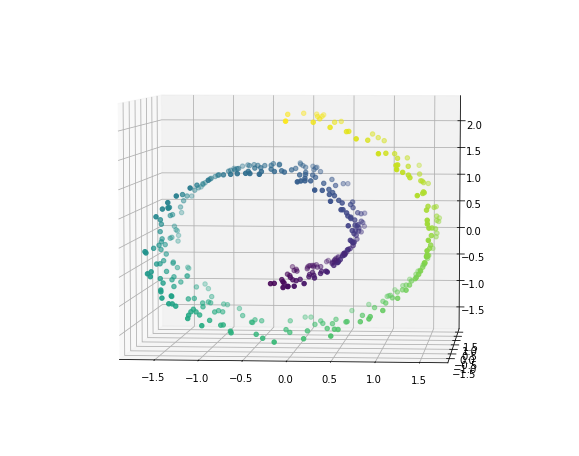

In [3]:
rcParams['figure.figsize'] = (10,8)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(5, -85)
ax.scatter(x[0,:], x[1,:], x[2,:], c=t_true, marker='o')
plt.show()

# Inferred Graph ($G$)

In [4]:
# build nearest neighbor graph
G = infer_graph(x, k=10, keep_asymmetries=True, delta=2.5)

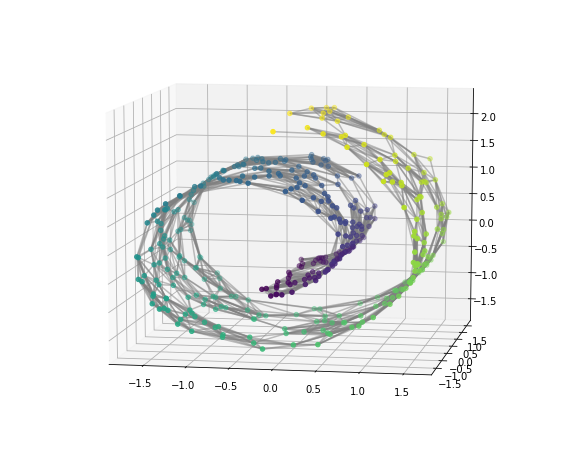

In [5]:
rcParams['figure.figsize'] = (10,8)
ax = plot_G(G=G, t=t_true, x=x, alpha_G=0.5)
ax.view_init(10, -80)

# Model

## Initialize $t$

In [6]:
t_init = initialize_t(G, x)

Correlation: -0.989793


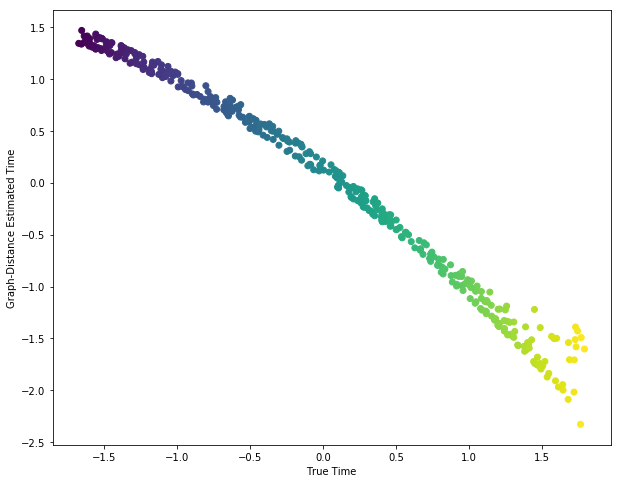

In [7]:
rcParams['figure.figsize'] = (10,8)
plt.scatter(t_true, t_init, c=t_true)
plt.xlabel("True Time")
plt.ylabel("Graph-Distance Estimated Time");
print("Correlation: %f" % np.corrcoef(t_true.flatten(), t_init.flatten())[0,1])

## Initialize $C$

In [8]:
C_init = initialize_C(x, t_init, G)

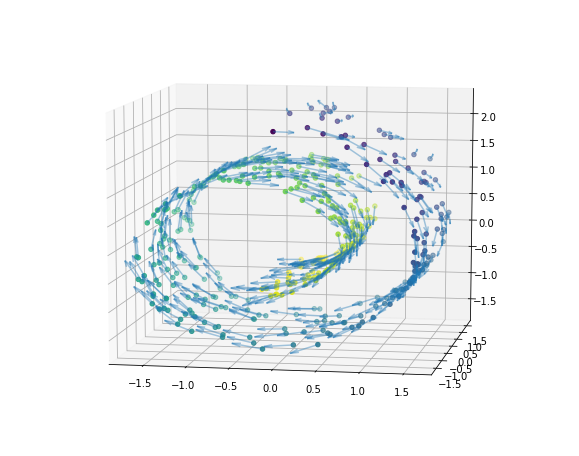

In [9]:
rcParams['figure.figsize'] = (10,8)
ax = plot_C_arrows(x, t_init, C_init, scale_C=0.1, alpha_C=0.4)
ax.view_init(10, -80)

## Initialize Model

In [10]:
#set user-defined parameters
alpha = 10
gamma = 5.0
epsilon = 0.00001
V_inv = gamma * np.identity(Dy)

model = LL_LVM(G, epsilon, alpha, V_inv, C_init, t_init, x, .0001, 0.01)

# Sampling

In [11]:
n_burn = 1000000

for i in range(n_burn):
    print("\rStep %d of %d; log-likelihood = %f" % (i+1,n_burn, model.likelihoods[-1]), end="")
    model.MH_step(burn_in=True)

Step 1000000 of 1000000; log-likelihood = -4571.677777

In [12]:
n_samp = 250000

for i in range(n_samp):
    print("\rStep %d of %d; log-likelihood = %f" % (i+1,n_samp, model.likelihoods[-1]), end="")
    model.MH_step(burn_in=False)

Step 250000 of 250000; log-likelihood = -4588.712649

In [13]:
print("Acceptance rate: %.8f" % model.accept_rate)

Acceptance rate: 0.40785600


# Likelihood Plot

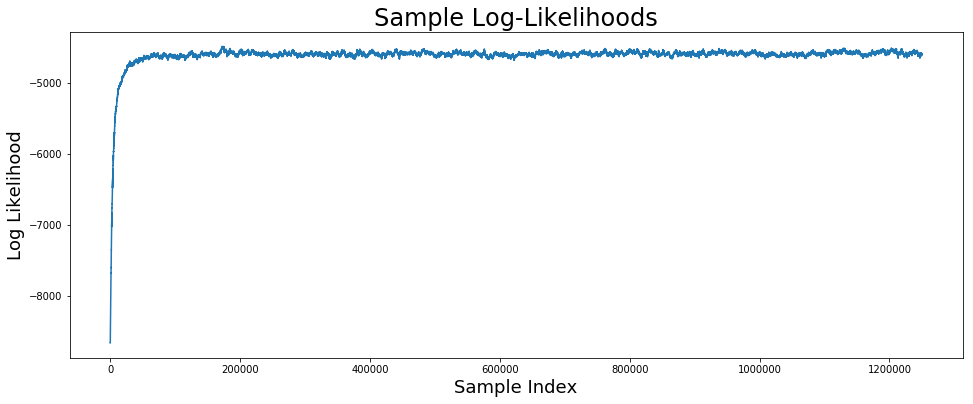

In [26]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.likelihoods)
plt.title("Sample Log-Likelihoods", fontsize=24)
plt.ylabel("Log Likelihood", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

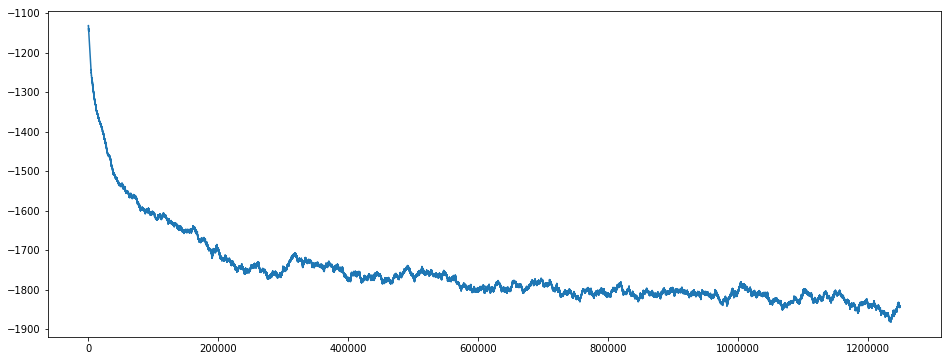

In [27]:
plt.plot(model.ll_comps['e'])

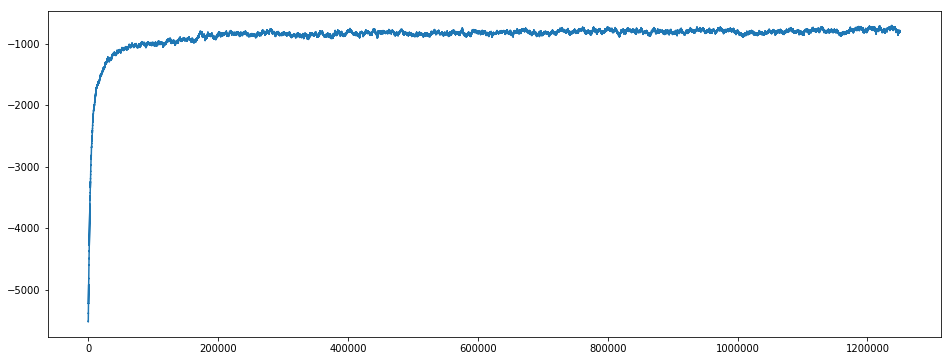

In [28]:
plt.plot(model.ll_comps['C'])

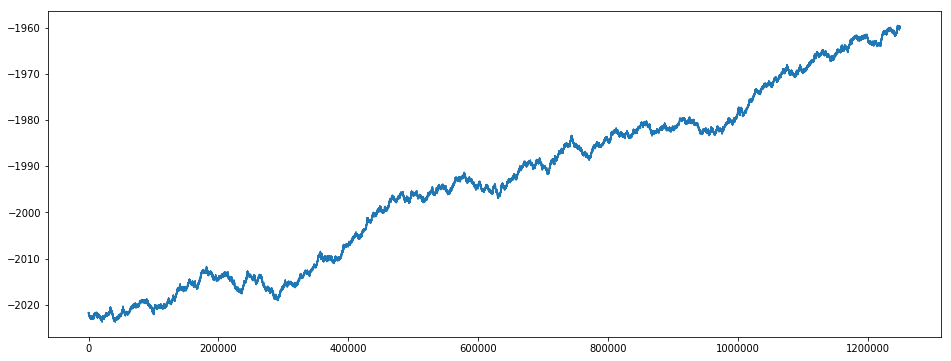

In [29]:
plt.plot(model.ll_comps['t'])

## $t$ versus $t_\text{true}$

Correlation: -0.988732


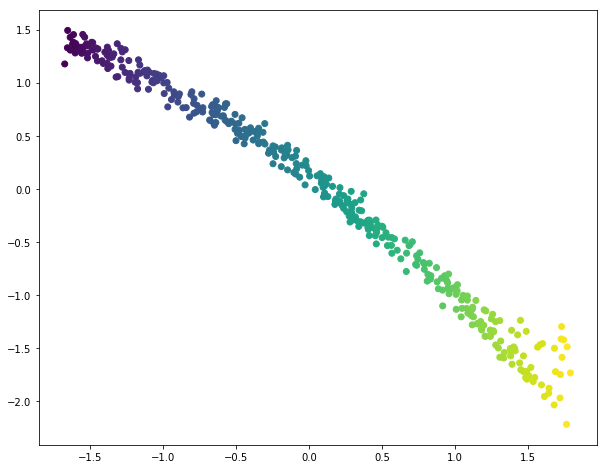

In [18]:
rcParams['figure.figsize'] = (10,8)
plt.scatter(t_true, model.t_mean, c=t_true);
print("Correlation: %f" % np.corrcoef(t_true.flatten(), model.t_mean.flatten())[0,1])

## Initial versus Sample $t$

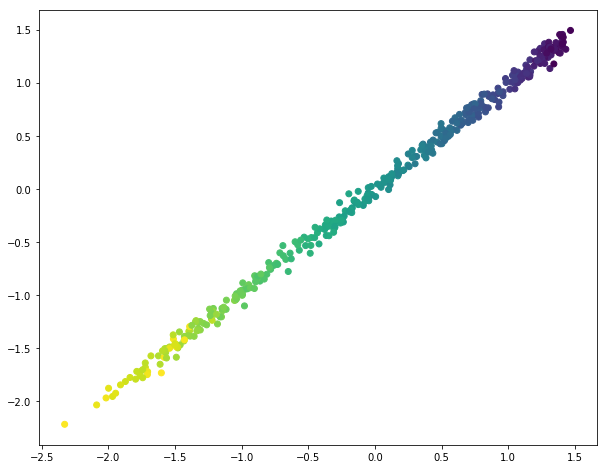

In [19]:
rcParams['figure.figsize'] = (10,8)
plt.scatter(t_init, model.t_mean, c=t_true.reshape((1,N)));

# $C$ Arrows

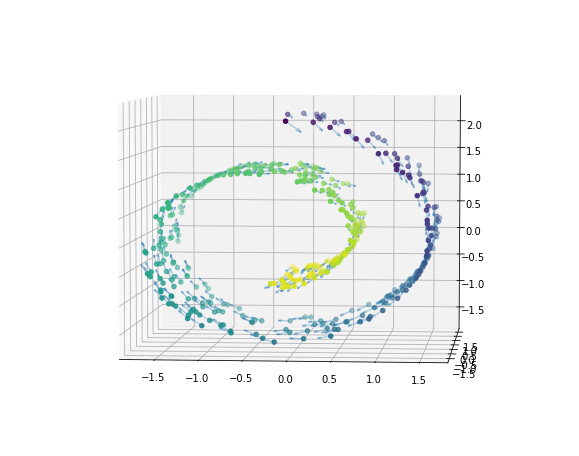

In [20]:
rcParams['figure.figsize'] = (10,8)
ax = plot_C_arrows(model.x, model.t_mean, model.C_mean, scale_C=0.1, alpha_C=0.3)
ax.view_init(5, -85)

## Version Information

In [21]:
%load_ext version_information
%version_information numpy, scipy, sklearn, matplotlib, version_information

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
IPython 6.2.1
OS Darwin 15.6.0 x86_64 i386 64bit
numpy 1.13.3
scipy 0.19.1
sklearn 0.19.1
matplotlib 2.1.0
version_information 1.0.3
Sat Nov 18 02:25:24 2017 EST